# Guia 3

## Ejercicio 1

La biblioteca dispone de la función `train_test_split`, que permite generar una partición de entrenamiento y prueba, y `KFold`, que genera varias particiones de validación cruzada.

Estudie el uso de estas funciones y utilícelas para generar particiones a partir del conjunto de datos `Digits` que en `Scikit-learn` puede cargarse usando la función `load_digits` del módulo `datasets`.

Mediante `MLPClassifier` construya un perceptrón multicapa adecuado para este conjunto de datos y analice su desempeño considerando:

- 1 unica partición de datos genererada mediante `train_test_split`,
- 5 particiones generadas mediante `KFold`,
- 10 particiones generadas mediante `KFold`.

Para el análisis tenga en cuenta la media y la varianza de la tasa de acierto obtenida en cada partición.

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPClassifier   
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from prettytable import PrettyTable
import time

# Cargar dataset
digits = load_digits()
x = digits.data
y = digits.target

# Definir el clasificador MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

# funcion para visualizar las particiones (https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#define-a-function-to-visualize-cross-validation-behavior)
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="muestra",
        ylabel="fold",
        ylim=[n_splits, -0.2]
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

### 1 Particion

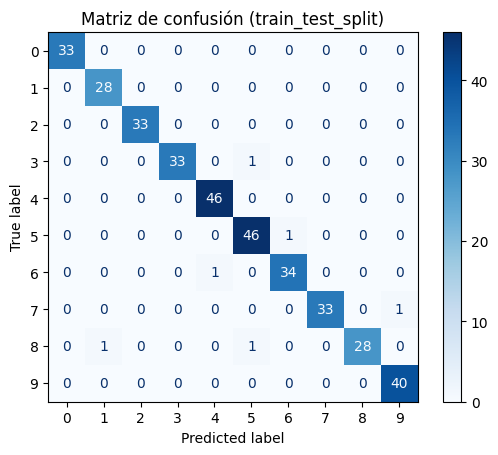

In [2]:
# separar entradas y salidas de train y test
x_trn, x_tst, y_trn, y_tst = train_test_split(x, y, test_size=0.2, random_state=42)

start_time = time.time()  # iniciar contador

# entrenar
mlp.fit(x_trn, y_trn)
# calcular salidas
y_pred = mlp.predict(x_tst)
# calcular precision (hits/total)
acc_1 = accuracy_score(y_tst, y_pred)

end_time = time.time()  # detener contador

tiempo_1 = end_time - start_time

# Matriz de confusión
cm = confusion_matrix(y_tst, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión (train_test_split)")
plt.show()

### Analisis por K-Fold

In [3]:
# funcion para calcular promedio y varianza de tasa de acierto para k folds
def evaluar_kfold(x, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    pred = []

    # calcular acc para cada fold
    for fold_idx, (trn_idx, tst_idx) in enumerate(kf.split(x)):
        x_trn, x_tst = x[trn_idx], x[tst_idx]
        y_trn, y_tst = y[trn_idx], y[tst_idx]

        mlp.fit(x_trn, y_trn)
        y_pred = mlp.predict(x_tst)
        acc = accuracy_score(y_tst, y_pred)
        accuracies.append(acc)

        pred.append((fold_idx, y_tst, y_pred))

    # promedio y varianza de accuracies
    mean_acc = np.mean(accuracies)
    var_acc = np.var(accuracies)
    return accuracies, mean_acc, var_acc, pred, kf

#### 5 Particiones

+------+----------+
| Fold | Accuracy |
+------+----------+
|  1   | 0.972222 |
|  2   | 0.966667 |
|  3   | 0.958217 |
|  4   | 0.980501 |
|  5   | 0.969359 |
+------+----------+


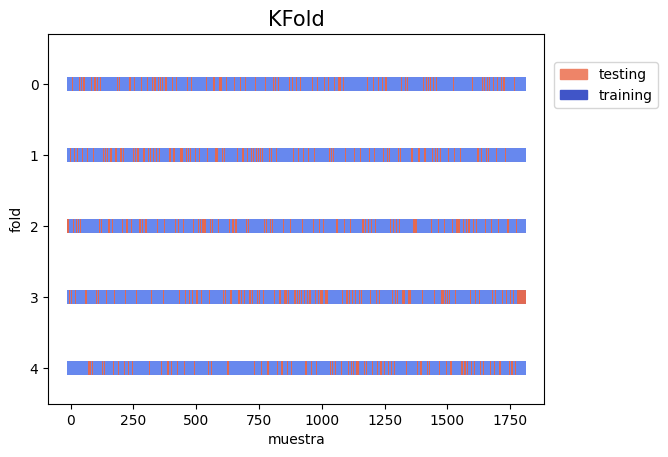

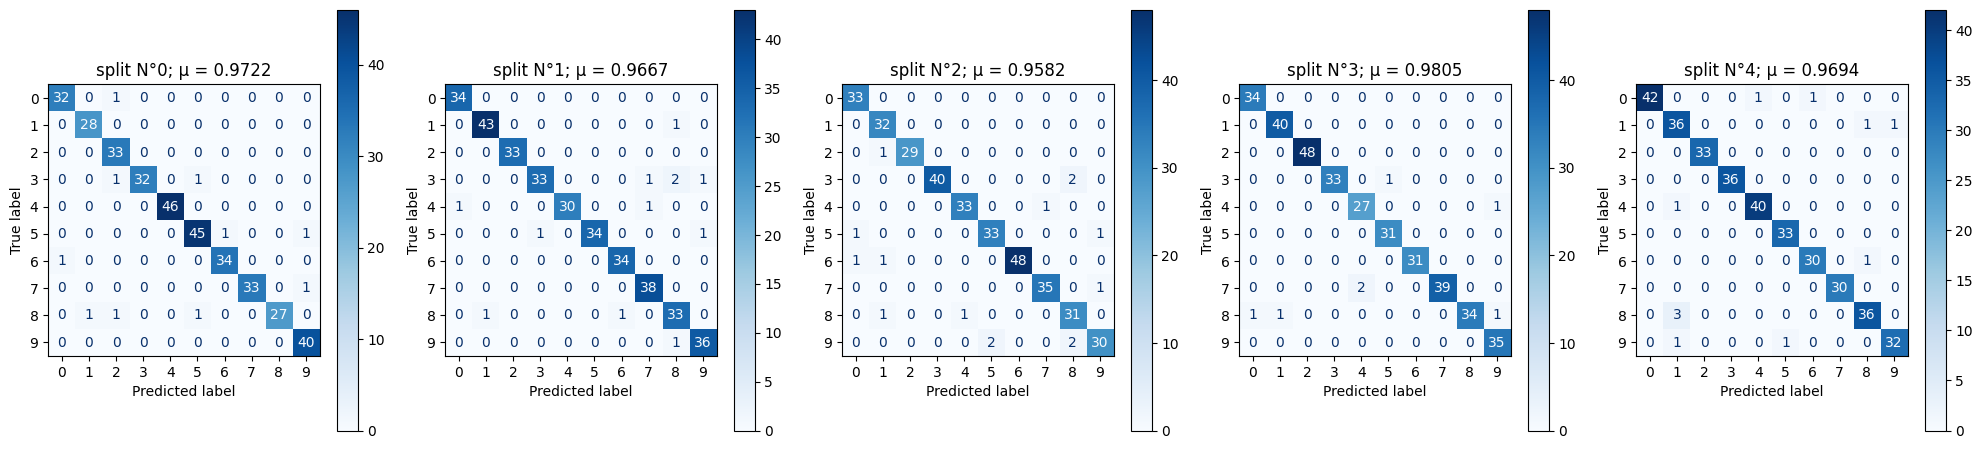

In [4]:
start_time = time.time()
acc_5, mean_acc_5, var_acc_5, pred_5, kf_5 = evaluar_kfold(x, y, 5)
end_time = time.time()

tiempo_5 = end_time - start_time

# Tabla de precisión por fold
table_5 = PrettyTable()
table_5.field_names = ["Fold", "Accuracy"]
for idx, acc in enumerate(acc_5, start=1):
    table_5.add_row([idx, f"{acc:.6f}"])
print(table_5)

fig, ax = plt.subplots()
plot_cv_indices(kf_5, x, y, ax, 5)
ax.legend(
    [Patch(color=plt.cm.coolwarm(0.8)), Patch(color=plt.cm.coolwarm(0.02))],
    ["testing", "training"],
    loc=(1.02, 0.8)
)

fig, ax = plt.subplots(1,5)
fig.set_figwidth(20)
fig.tight_layout()
for i in range(len(ax)):
    _, y_tst, y_pred = pred_5[i]
    ax[i].set_title(f"split N°{i}; μ = {acc_5[i]:.4f}")
    ConfusionMatrixDisplay.from_predictions(y_tst, y_pred, ax=ax[i], cmap="Blues", values_format="d")

#### 10 Particiones

In [5]:
start_time = time.time()
acc_10, mean_acc_10, var_acc_10, pred_10, kf_10 = evaluar_kfold(x, y, 10)
end_time = time.time()

tiempo_10 = end_time - start_time

+------+----------+
| Fold | Accuracy |
+------+----------+
|  1   | 0.988889 |
|  2   | 0.983333 |
|  3   | 0.972222 |
|  4   | 0.955556 |
|  5   | 0.972222 |
|  6   | 0.977778 |
|  7   | 0.977778 |
|  8   | 0.977654 |
|  9   | 0.983240 |
|  10  | 0.966480 |
+------+----------+


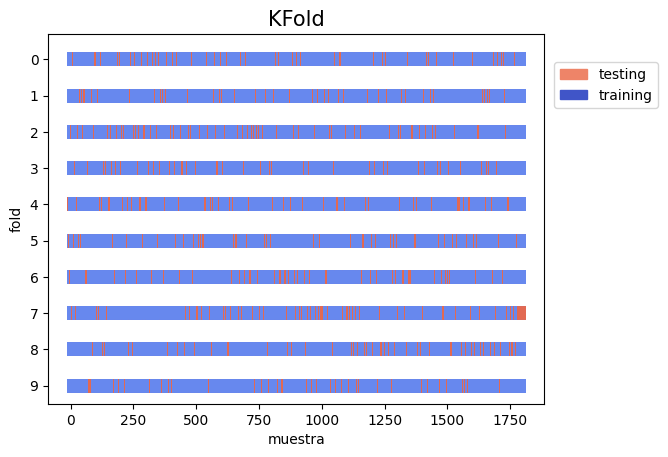

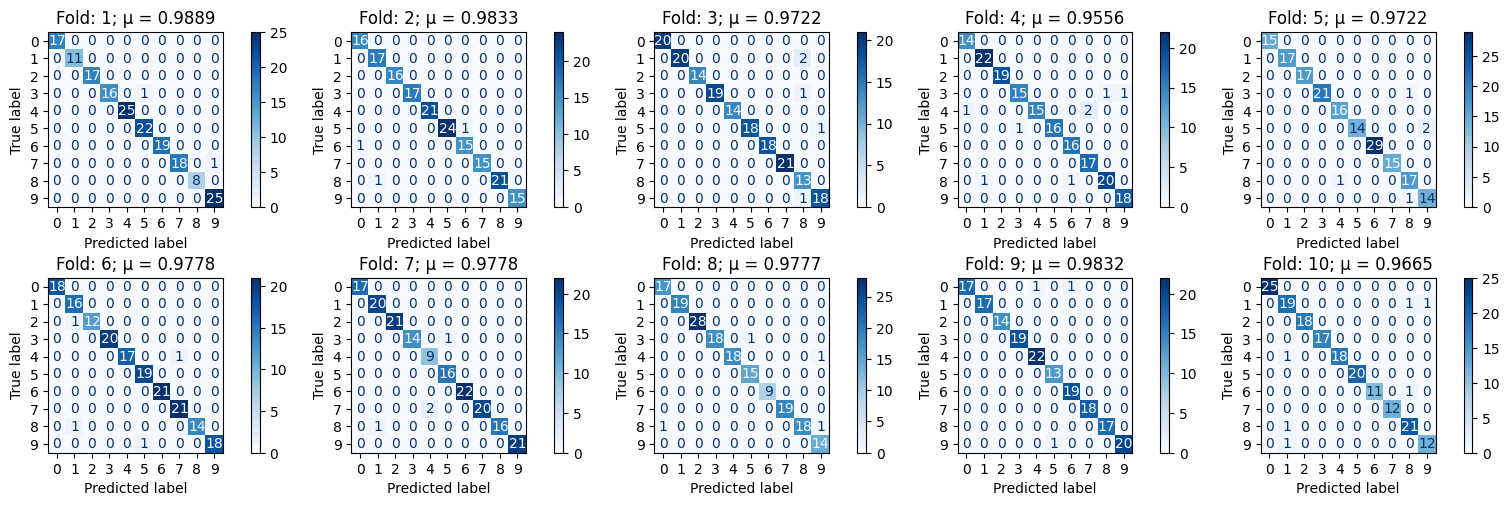

In [6]:
# Tabla de precisión por fold
table_10 = PrettyTable()
table_10.field_names = ["Fold", "Accuracy"]
for idx, acc in enumerate(acc_10, start=1):
    table_10.add_row([idx, f"{acc:.6f}"])
print(table_10)

fig, ax = plt.subplots()
plot_cv_indices(kf_10, x, y, ax, 10)
ax.legend(
    [Patch(color=plt.cm.coolwarm(0.8)), Patch(color=plt.cm.coolwarm(0.02))],
    ["testing", "training"],
    loc=(1.02, 0.8)
)

fig, ax = plt.subplots(2,5)
fig.tight_layout(h_pad=3, w_pad=-9)
fig.set_figwidth(20)
for i in range(2):
    for j in range(5):
        _, y_tst, y_pred = pred_10[i*5 + j]
        ax[i,j].set_title(f"Fold: {i*5 + j + 1}; μ = {acc_10[i*5 + j]:.4f}")
        ConfusionMatrixDisplay.from_predictions(y_tst, y_pred, ax=ax[i,j], cmap="Blues", values_format="d")

### Conclusiones

In [7]:
resumen = PrettyTable()
resumen.field_names = ["Analisis", "μ", "σ²", "Tiempo"]
resumen.add_row(["No fold", f"{acc_1:.4f}", "-", f"{tiempo_1:.6f}"])
resumen.add_row(["5-Fold", f"{mean_acc_5:.4f}", f"{var_acc_5:.6f}", f"{tiempo_5:.4f}"])
resumen.add_row(["10-Fold", f"{mean_acc_10:.4f}", f"{var_acc_10:.6f}", f"{tiempo_10:.4f}"])
print(resumen)

+----------+--------+----------+----------+
| Analisis |   μ    |    σ²    |  Tiempo  |
+----------+--------+----------+----------+
| No fold  | 0.9833 |    -     | 0.609615 |
|  5-Fold  | 0.9694 | 0.000053 |  2.6658  |
| 10-Fold  | 0.9755 | 0.000082 |  6.2381  |
+----------+--------+----------+----------+


Aunque para una unica particion grande el analisis es mas rapido, la tasa de error resultante es muy sencible a la particion que se crea, que puede no ser representativa del dataset completo. Por ejemplo, pueden haber tocado justo casos muy sesgados.

Para la validación cruzada, se divide el conjunto de datos en k subconjuntos, se entrena con k-1 subconjuntos y se usa el restante para testing, por lo que al aumentar k tengo menos datos de prueba, lo que puede aumentar la varianza entre las particiones, pero reduce la sensibilidad a la partición (los subconjuntos son más variables, por lo que es reduce la probabilidad de obtener particiones que provoquen resultados sesgados). También tarda más al aumentar k, porque tiene que evaluar para más particiones